TITLE

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from itertools import permutations

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("dec_data.csv")

In [53]:
df.head()

,Name,100 metres,Long jump,Shot put,High jump,400 metres,110 hurdles,Discus,Pole vault,Javelin,1500 metres,Total Points
0,Damian Warner 2016 Olympics,10.30,7.67,13.66,2.04,47.35,13.58,44.93,4.7,63.19,264.90,8666
1,Ashton Eaton 2016 Olympics,10.46,7.94,14.73,2.01,46.07,13.80,45.49,5.2,59.77,263.33,8893
2,Zach Ziemek 2016 Olympics,10.71,7.49,13.44,2.10,49.83,14.77,49.42,5.2,60.92,282.97,8392
3,Rico Freimuth 2016 Olympics,10.73,7.17,13.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2460
4,Larbi Bourrada 2016 Olympics,10.75,7.52,13.78,2.10,47.98,14.15,42.39,4.6,66.49,254.60,8521


Making a histogram of all the features, see skew etc

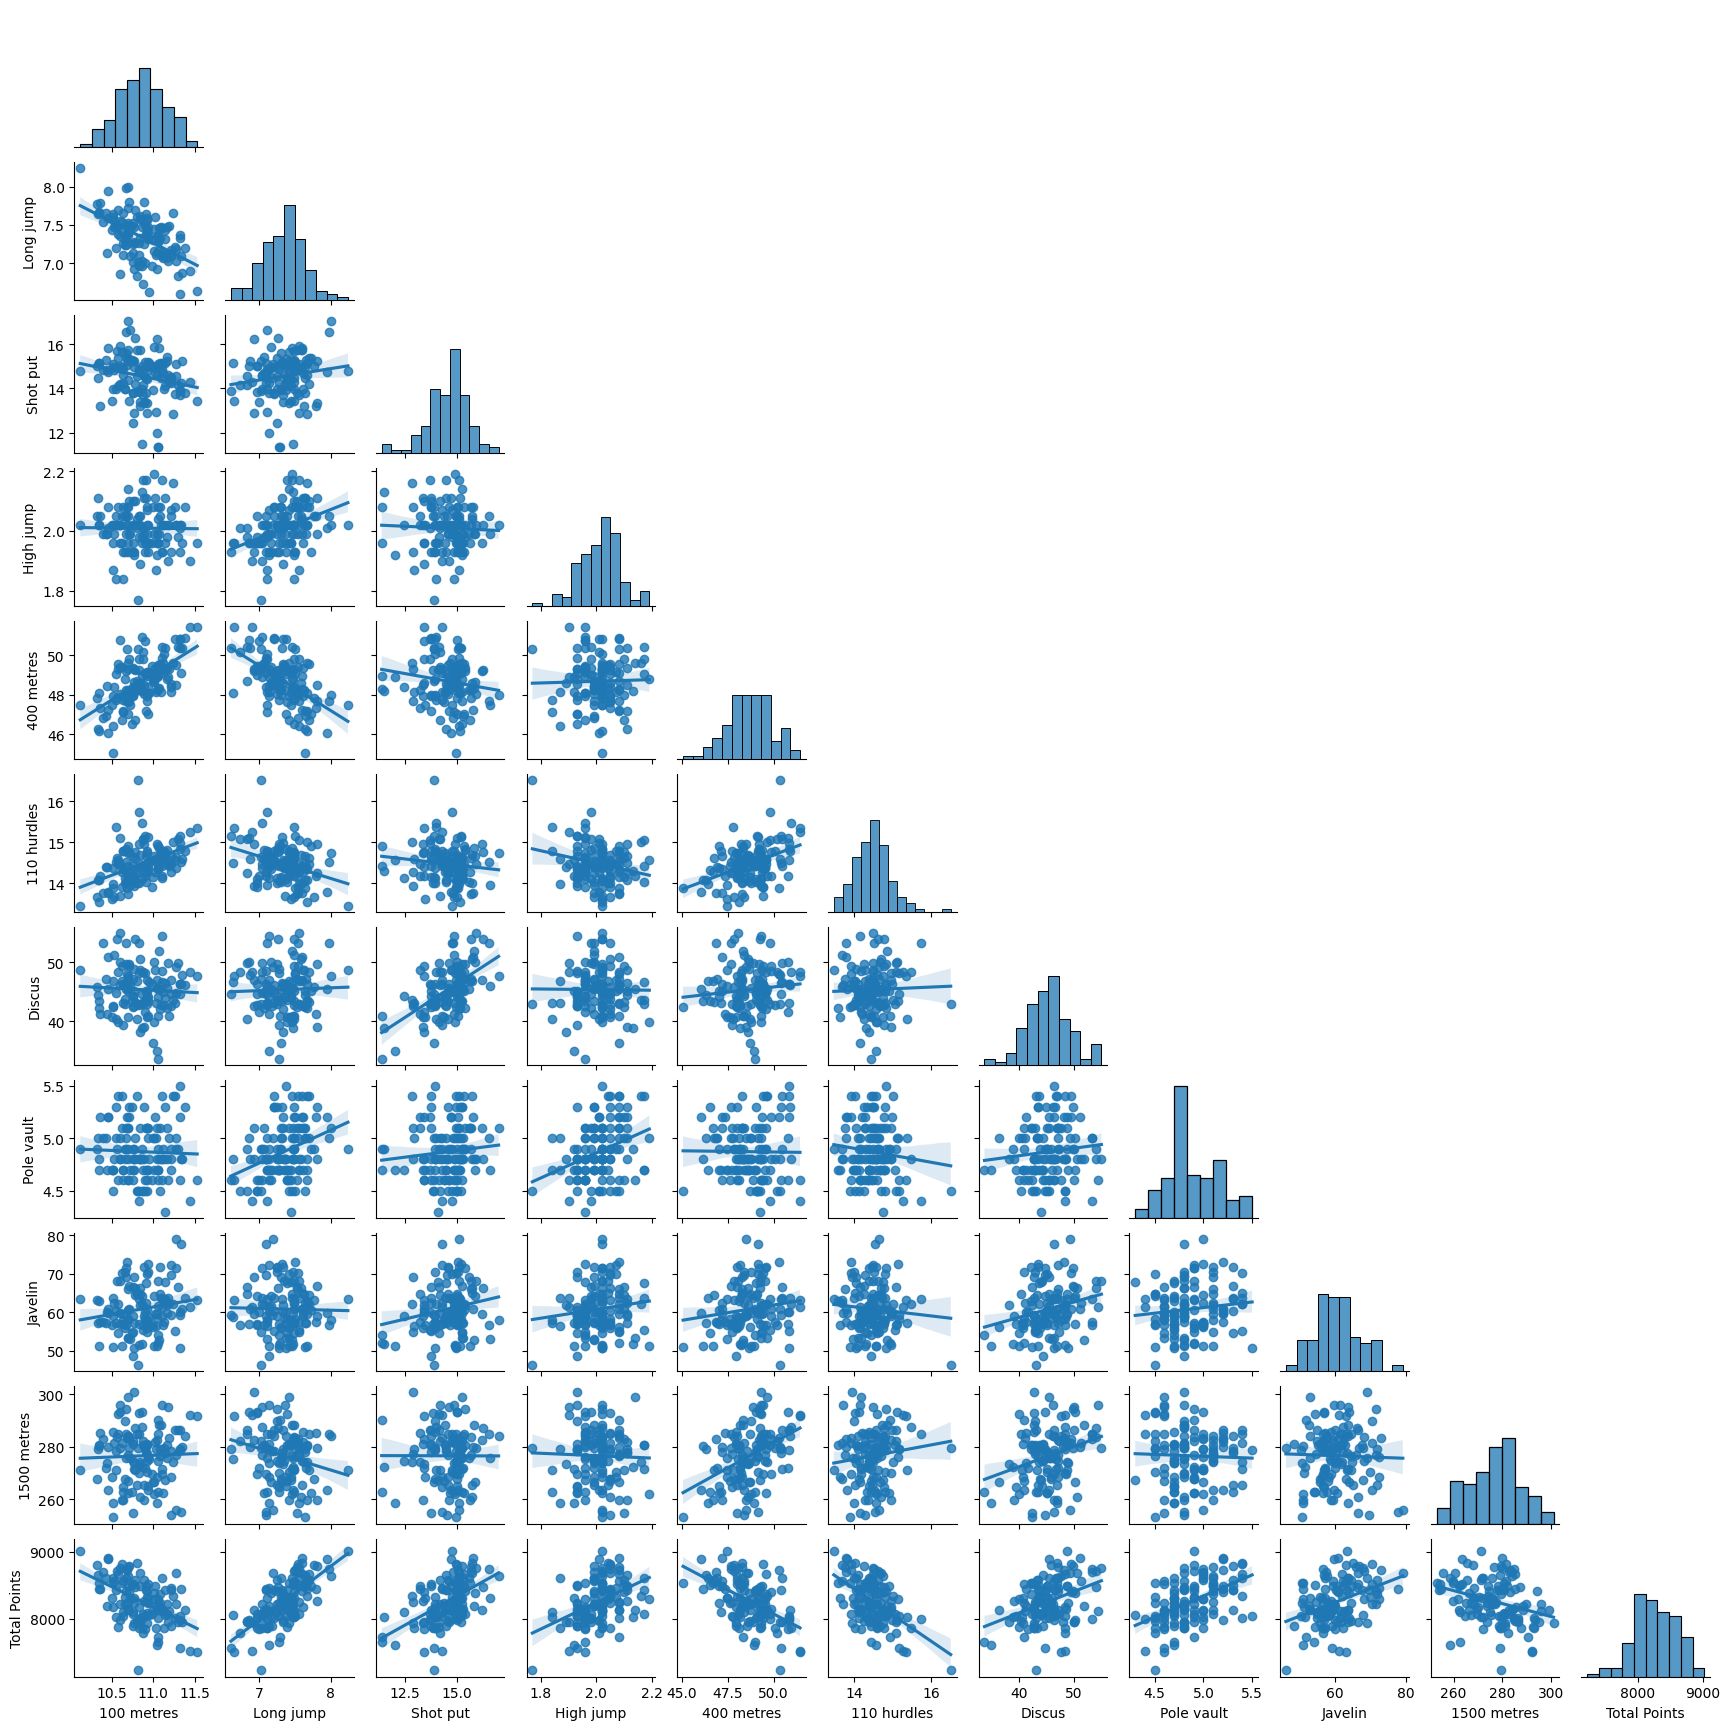

In [3]:
sns.pairplot(df[1:], kind = "reg", corner = True, height = 1.6)

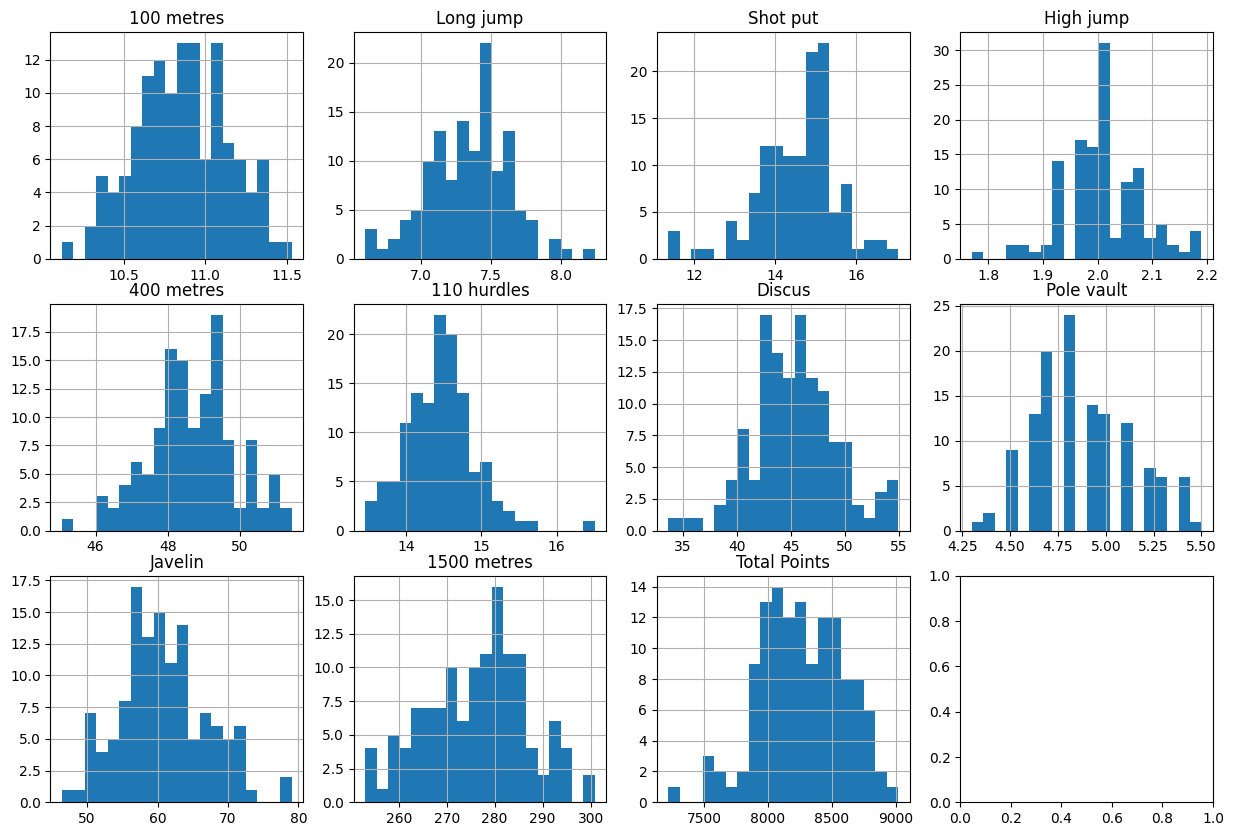

In [4]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize = (15,10))
ax = ax.ravel()
cols = df.columns[1:]
for col, ax in zip(cols, ax):
    df[col].hist(bins=20, ax=ax)
    ax.set_title(col)

Making a Box Plot, checking outliers

<Axes: xlabel='Event', ylabel='Score'>

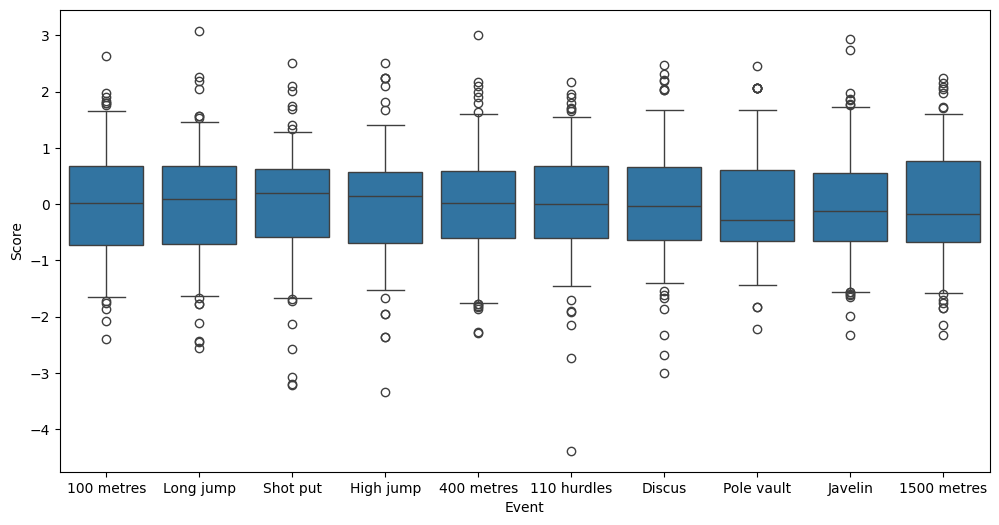

In [5]:
y_axis = df["Total Points"]
name = df["Name"]
track_events = ['100 metres', '400 metres', '110 hurdles', '1500 metres']
standardized_df = df.copy()
standardized_df[track_events] = -1 * standardized_df[track_events]
standardized_df = standardized_df.drop(columns = ["Total Points", "Name"])
scaler = StandardScaler()
scaler.fit(standardized_df)
standardized_df = pd.DataFrame(scaler.transform(standardized_df), columns=standardized_df.columns)
standardized_df = pd.concat([standardized_df, y_axis], axis = 1)
vertical_df = pd.melt(standardized_df, id_vars = "Total Points", var_name='Event', value_name='Score')
plt.figure(figsize=(12, 6))
sns.boxplot(data = vertical_df, x = "Event", y = "Score", whis=[5, 95])

In [6]:
min_hurdles = df.loc[df['110 hurdles'].idxmax()]
min_hurdles
#Min hj/hurdles

Name            Karl Robert Saluri 2016 Olympics
100 metres                                 10.82
Long jump                                   7.02
Shot put                                   13.88
High jump                                   1.77
400 metres                                 50.32
110 hurdles                                16.51
Discus                                     42.96
Pole vault                                   4.5
Javelin                                    46.42
1500 metres                                279.4
Total Points                                7223
Name: 8, dtype: object

In [7]:
standardized_df.loc[standardized_df['110 hurdles'].idxmin()]
#z score of -4, -=3, and -2 indicates a really weird performance

100 metres         0.126797
Long jump         -1.117972
Shot put          -0.676824
High jump         -3.342846
400 metres        -1.362235
110 hurdles       -4.383985
Discus            -0.616283
Pole vault        -1.443196
Javelin           -2.334859
1500 metres       -0.280740
Total Points    7223.000000
Name: 8, dtype: float64

In [8]:
min_shotput = df['Discus']
min_shotput.sort_values()

119    33.65
16     34.91
116    36.33
10     38.09
11     38.89
       ...  
100    53.33
93     53.91
63     53.92
71     54.39
78     54.97
Name: Discus, Length: 128, dtype: float64

In [9]:
df_total = df['Total Points']
df_total.sort_values()

8      7223
127    7498
38     7516
106    7566
16     7612
       ... 
61     8816
7      8834
1      8893
77     8909
39     9018
Name: Total Points, Length: 128, dtype: int64

The goal is to figure out which event coorelates best with score meaning that a atypical performance skews data, as we are trying to find relationship with events. Because of this, I researched into the athletes and found their typical perfomance.
It looks like Karl Robert Saluri 2016 Olympics was sick or something, so I will remove his score.
11.37 and 11.49 SP and bottom two discs were both from the same two people, so not an outlier performance.
Outlier positive values are ignored since there is little luck in track

In [10]:
df = df[df['Name'] != 'Karl Robert Saluri 2016 Olympics']

Now no more outlieres, I can start finding coorelation. Starting with heatmap

<Axes: >

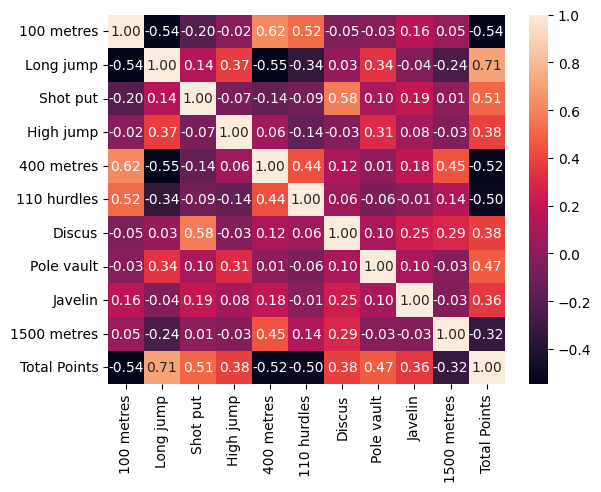

In [11]:
df_heatmap = df.drop("Name", axis = 1)
sns.heatmap(df_heatmap.corr(), annot = True, fmt = '0.2f')

It looks like longjump has the highest coorelation with total points out of the other events, and 1500 has the lowest (obviously). Is this statistically significant?

Converting score to points

In [12]:
def Calculate_Track(num):
    if num == 1:
        A = 25.4347
        B=18
        C=1.81
    if num == 5:
        A=1.53775
        B=82
        C=1.81
    if num == 6:
        A=5.74352
        B=28.5
        C=1.92
    if num == 10:
        A=0.03768
        B=480
        C=1.85
    return A,B,C
def Calculate_Field(num):
    #cm
    if num == 2:
        A=0.14354
        B=220
        C=1.4
    #m
    if num == 3:
        A=51.39
        B=1.5
        C=1.05
    #cm
    if num == 4:
        A=0.8465
        B=75
        C=1.42
    if num == 7:
        A=12.91
        B=4
        C=1.1
    #cm
    if num == 8:
        A=0.2797
        B=100
        C=1.35
    if num == 9:
        A=10.14
        B=7
        C=1.08
    return A,B,C
points_df = df.copy()
for i in range (1,11):
    column_data = points_df.iloc[:, i]
    if i in {1,5,6,10}:
        A,B,C = Calculate_Track(i)
        points_df.iloc[:,i] = np.trunc((A*(B-column_data)**C))
    else:
        A,B,C = Calculate_Field(i)
        if i in {2,4,8}:
            column_data = column_data * 100
        points_df.iloc[:,i] = np.trunc(A*(column_data-B)**C)
points_df.head(5)

,Name,100 metres,Long jump,Shot put,High jump,400 metres,110 hurdles,Discus,Pole vault,Javelin,1500 metres,Total Points
0,Damian Warner 2016 Olympics,1023.0,977.0,708.0,840.0,941.0,1029.0,765.0,819.0,786.0,778.0,8666
1,Ashton Eaton 2016 Olympics,985.0,1045.0,773.0,813.0,1005.0,1000.0,777.0,972.0,734.0,789.0,8893
2,Zach Ziemek 2016 Olympics,926.0,932.0,694.0,896.0,822.0,878.0,858.0,972.0,752.0,662.0,8392
3,Larbi Bourrada 2016 Olympics,917.0,940.0,715.0,896.0,910.0,955.0,713.0,790.0,836.0,849.0,8521
4,Luiz Alberto de Araújo 2016 Olympics,912.0,930.0,806.0,731.0,902.0,953.0,769.0,880.0,697.0,735.0,8315


Note: heatmap doesnt change (except for rounding errors) when converting to points

<Axes: >

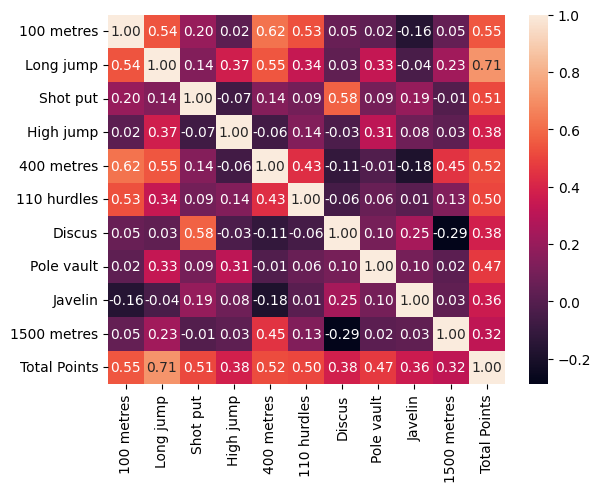

In [13]:
points_df_heatmap = points_df.drop(columns = "Name")
sns.heatmap(points_df_heatmap.corr(), annot = True, fmt = '0.2f')

In [14]:
#print out the average points per event
rows = []
for i in range (1,11):
    rows.append({"Event": df.columns[i], "Mean Points": float(points_df.iloc[:,i].mean())})
event_score_mean = pd.DataFrame(rows)
event_score_mean.sort_values(by = "Mean Points")

,Event,Mean Points
9,1500 metres,704.377953
8,Javelin,753.023622
2,Shot put,762.685039
6,Discus,775.000000
3,High jump,814.874016
7,Pole vault,872.574803
4,400 metres,877.755906
0,100 metres,893.944882
1,Long jump,898.173228
5,110 hurdles,917.732283


In [15]:
points_df["Discus"].sum()

np.float64(98425.0)

Now I make conversions

In [16]:
columns = ['From_Event', 'To_Event', 'alpha', 'beta', 'error', 'r_squared']
event_models_df = pd.DataFrame(columns=columns)

events = points_df.columns.tolist()
events.pop(0)

for input_event, output_event in permutations(events, 2):
    x = points_df[input_event]
    x=x.to_frame()
    y = points_df[output_event]
    y=y.to_frame()
    
    model = LinearRegression().fit(x,y)
    residuals = y - model.predict(x)
    error = np.std(residuals, axis = 0)
    error = float(error.iloc[0])
    alpha = float(model.coef_[0][0])
    beta = float(model.intercept_[0])
    r_squared = model.score(x, y)
    
    event_models_df = pd.concat([event_models_df, pd.DataFrame([{
            'From_Event': input_event,
            'To_Event': output_event,
            'alpha': alpha,
            'beta': beta,
            'error': error,
            'r_squared': r_squared
        }])], ignore_index=True)

event_models_df['r_squared'].sort_values()

28     0.000093
92     0.000093
85     0.000158
57     0.000158
46     0.000189
         ...   
62     0.331614
3      0.381722
40     0.381722
19     0.508745
101    0.508745
Name: r_squared, Length: 110, dtype: float64

In [17]:
event_models_df.iloc[19]

From_Event       Long jump
To_Event      Total Points
alpha              3.21087
beta            5386.22469
error           223.495411
r_squared         0.508745
Name: 19, dtype: object

In [18]:
event_models_df.iloc[3]

From_Event    100 metres
To_Event      400 metres
alpha           0.554379
beta          382.171699
error          44.956892
r_squared       0.381722
Name: 3, dtype: object

The r squared values are just the heatmap values but squared, so the highest coorelations should still apply

In [51]:
event_models_df.head()

,From_Event,To_Event,alpha,beta,error,r_squared
0,100 metres,Long jump,0.602426,359.637762,59.531340,0.293673
1,100 metres,Shot put,0.188026,594.600240,59.814778,0.038573
2,100 metres,High jump,0.019525,797.419334,63.253981,0.000387
3,100 metres,400 metres,0.554379,382.171699,44.956892,0.381722
4,100 metres,110 hurdles,0.447643,517.563743,45.734982,0.280040


In [48]:
def Calculate_Expected_Scores(event, points, confidence):
    event_conversion_df = event_models_df[event_models_df["From_Event"] == event]

    index_df = pd.Series(points_df.columns)
    base_event = int(index_df[index_df == event].index[0])
    
    expected_ranges = []
    num = 1
    for index, row in event_conversion_df.iterrows():
        #skips comparison of its own event
        if num == base_event:
            num = num + 1
            
        expected_points_lower = points * row["alpha"] + row["beta"] - confidence * row["error"]
        expected_points_upper = points * row["alpha"] + row["beta"] + confidence * row["error"]
        
        if num in {1,5,6,10}:
            A,B,C = Calculate_Track(num)
            expected_score_lower = B - (expected_points_lower/A)**(1/C)
            expected_score_upper = B - (expected_points_upper/A)**(1/C)
        elif num in {2,3,4,7,8,9}:
            A,B,C = Calculate_Field(num)
            expected_score_lower = (expected_points_lower/A)**(1/C)+B
            expected_score_upper = (expected_points_upper/A)**(1/C)+B
            if num in {2,4,8}:
                expected_score_lower = expected_score_lower/100
                expected_score_upper = expected_score_upper/100
        expected_range = {row["To_Event"]: [round(expected_score_lower,2), round(expected_score_upper,2)]}
        expected_ranges.append(expected_range)
        
        num = num + 1
    print(expected_ranges)
    
Calculate_Expected_Scores("100 metres", 1, 1)

[{'Long jump': [4.56, 5.19]}, {'Shot put': [10.81, 12.78]}, {'High jump': [1.92, 2.06]}, {'400 metres': [62.33, 59.59]}, {'110 hurdles': [18.56, 17.6]}, {'Discus': [38.43, 46.28]}, {'Pole vault': [4.52, 5.04]}, {'Javelin': [68.78, 80.57]}, {'1500 metres': [294.52, 272.76]}, {'Total Points': [294.52, 272.76]}]


In [21]:
points_df["Long jump"].mean()

np.float64(898.1732283464567)

In [22]:
points_df["100 metres"].mean()

np.float64(893.9448818897638)

In [23]:
points_df.loc[106]

Name            Daniel Golubovic 2024 Olympics
100 metres                               791.0
Long jump                                720.0
Shot put                                 722.0
High jump                                740.0
400 metres                               798.0
110 hurdles                              831.0
Discus                                   760.0
Pole vault                               790.0
Javelin                                  728.0
1500 metres                              686.0
Total Points                              7566
Name: 106, dtype: object